# 1.1 分子の正規化
外部から取得する化合物情報には塩や、金属が含まれていることや、互変異性体が混在していることがあります。従って扱う前に適切な処理を施して標準化、正規化する処理が必要になります。本ハンズオンではRDKit, [chembl_structure_pipeline](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00456-1)を利用し、テストデータを用いて標準化、正規化を行います。
これ以外に[Mellody Tuner](https://github.com/melloddy/MELLODDY-TUNER/tree/master)というパッケージにも正規化のコマンドがあります。動作がChembl structure pipelineとは異なりますので興味のある方は調べてみて下さい。
本ハンズオンでの正規化の流れは以下となります。

1. 排除リストに載っている金属イオンを含む化合物を除去
1. chembl_structure_pipelineによる標準化とおかしな化合物を除去
1. 互変異体の対応

注) 実際の業務においては、社内の化合物登録システムで利用する正規化ルールがあるのでそれらに準拠することが必要です。

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw

from chembl_structure_pipeline import standardizer
from chembl_structure_pipeline import get_parent_mol

import rdkit
import chembl_structure_pipeline
import pathlib
import sys
import os
#　実行するノートブックのパスを取得します
notedir = pathlib.Path().resolve()
print(notedir)
#InteractiveRenderer.setEnabled(True)
print(rdkit.__version__)
print(chembl_structure_pipeline.__version__)

[22:11:10] Initializing Normalizer


/home/iwatobipen/dev/CBI/cheminfotutorial1023/01_dataprep
2023.03.3
1.2.0


 Pubchem FTPから取得したテストデータを読み込みます。以下のコードではChem.SDMolSupplierではなくMolBlock単位で読み込んでいます。
 SDFをChem.ForwardSDMolSupplierで読み込むのが一般的かと思いますが、最初の1000件だけを読みたいため$$$で区切りMolBlock単位で読んでいます。全件処理するようであれば、ForwardSDMolSupplierを使えばsdf.gzをそのまま読み込めます。
```python
# example
import gzip
suppl = ForwardSDMolSupplier(gzip.open('in.sdf.gz'))
for mol in suppl:
  if mol is not None: print mol.GetNumAtoms()
```


In [2]:
#　wget https://ftp.ncbi.nlm.nih.gov/pubchem/Substance/CURRENT-Full/SDF/Substance_000000001_000500000.sdf.gz
import gzip
with gzip.open(os.path.join(notedir, 'Substance_000000001_000500000.sdf.gz')) as inf:
    records = []
    record = []
    for line in inf:
        record.append(line)
        if line == b'$$$$\n':
            records.append(b''.join(record).decode())
            record = []
        if len(records)>=1000:
            break

## structurepipeline.check_molblock
molblockを入力として構造をチェックし結果を返します。結果はタプルとして返されます。該当する項目があった場合はその情報がタプル内に含まれます。 chembl_structure_pipelineでは以下の項目が評価されます。

  - PolymerFileChecker,
  - V3000FileChecker,
  - NumAtomsMolChecker,
  - Has3DMolChecker,
  - Has3DFlagSetMolChecker,
  - HasIllegalBondTypeMolChecker,
  - HasIllegalBondStereoMolChecker,
  - HasMultipleStereoBondsMolChecker,
  - HasManyOverlappingAtomsMolChecker,
  - HasOverlappingAtomsMolChecker,
  - ZeroCoordsMolChecker,
  - HasCrossedRingBondMolChecker,
  - HasStereoBondInRingMolChecker,
  - HasStereoBondToStereocenterMolChecker,
  - DisallowedRadicalMolChecker,
  
  最初の30化合物に対して評価してみます。

In [3]:
for i, record in enumerate(records):
    res = chembl_structure_pipeline.check_molblock(record)
    if res:
        print("#"+str(i), res)
    if i == 30:
        break

#1 ((6, 'InChI: Accepted unusual valence(s)'), (2, 'InChI: Proton(s) added/removed'), (2, 'InChI: Metal was disconnected'))
#4 ((7, 'Error 76 (no InChI; Invalid element(s): *) inp'), (5, 'RDKit_Mol/InChI stereo mismatch'), (2, 'molecule has an atom with multiple stereo bonds'))
#5 ((7, 'Error 76 (no InChI; Invalid element(s): *) inp'), (5, 'RDKit_Mol/InChI stereo mismatch'))
#7 ((7, 'InChI: Unknown element(s)'),)
#8 ((7, 'InChI: Unknown element(s)'),)
#10 ((7, 'Error 76 (no InChI; Invalid element(s): *) inp'),)
#16 ((5, 'Mol/Inchi/RDKit stereo mismatch'),)
#17 ((2, 'molecule has an atom with multiple stereo bonds'),)
#18 ((2, 'molecule has an atom with multiple stereo bonds'),)
#19 ((2, 'molecule has an atom with multiple stereo bonds'),)
#20 ((2, 'molecule has an atom with multiple stereo bonds'),)
#21 ((6, 'InChI: Accepted unusual valence(s)'), (2, 'InChI: Proton(s) added/removed'), (2, 'InChI: Metal was disconnected'))
#22 ((6, 'InChI: Accepted unusual valence(s)'), (2, 'InChI: Prot

## 構造とchembl_structure_pipelineの評価結果の表示
chembl_structure_pipelineの動作を確認したので、今度は[ipywidgets](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html)を使いインタラクティブに構造を確認します。


注) 今回はハンズオンなのでこのような形を取りますが、レコード数が多くなるとブラウザがフリーズすると思われます。

In [4]:
from ipywidgets import interact,fixed
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

@interact(idx=range(0,len(records)),records=fixed(records))
def show_mol(idx,records):
    record = records[idx]
    print(chembl_structure_pipeline.check_molblock(record))
    # sanitize FalseにしているのでSanitizeが失敗するMolBlockも読み込んで描画します。
    m = Chem.MolFromMolBlock(record,sanitize=False)
    # UpdatePropertyCache()を使いValenceを計算します。これは上段でSanitize=FalseにしておりValenceなどの計算がされないためです。
    m.UpdatePropertyCache()
    Chem.GetSymmSSSR(m)
    d2d = rdMolDraw2D.MolDraw2DSVG(450,400)
    # prepareMolsBeforeDrawing=True にすると描画前に分子をきれいにしてくれます（2D配座）。
    d2d.drawOptions().prepareMolsBeforeDrawing=False
    d2d.DrawMolecule(m)
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

## TIPs RDKitのsanitizationについて
- RDKitのsanitizationは以下の順序で行われます。
    1. clearComputedProps
    2. cleanUp
    3. updatePropertyCache
    4. symmetrizeSSSR
    5. Kekulize
    6. assignRadicals
    7. setAromaticity
    8. setConjugation
    9. setHybridization
    10. cleanupChirality
    11. adjustHs
    12. updatePropertyCache
 - [詳細はオフィシャルドキュメント参照link](https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization)

## index 469の分子はExcludedフラグが立ちます。これはChembl_structure_pipeline内に定義された金属原子を含む分子であることを示します。
- METAL_LIST以下のコードから確認できます
- これらの金属原子を含む分子は処理から除外されます。このような分子を正規化したい場合は、別途金属原子を別のアプローチで金属を除外する必要があります。
- 必要に応じて対応しましょう。

In [5]:
from chembl_structure_pipeline import exclude_flag
print(exclude_flag.METAL_LIST)

{'W', 'Mn', 'V', 'Sm', 'Tb', 'Hf', 'Fm', 'Sb', 'Au', 'Dy', 'Tl', 'Pb', 'Os', 'Ce', 'Ho', 'U', 'Nb', 'Yb', 'Pu', 'Re', 'Pm', 'Es', 'Hg', 'Md', 'Lu', 'Pr', 'Cf', 'Pd', 'Am', 'Bi', 'Np', 'Tm', 'Lr', 'Cu', 'In', 'Pt', 'Sc', 'Ac', 'Cd', 'Sn', 'Co', 'Ga', 'Rh', 'Po', 'Ir', 'Fe', 'Ge', 'Er', 'Y', 'Th', 'Pa', 'Ti', 'Tc', 'Mo', 'No', 'Zr', 'Ni', 'La', 'Ta', 'Nd', 'Eu', 'Bk', 'Cr', 'Cm', 'Gd', 'Ru'}


## standardize_molblock method 実行時にexcludeされた分子かどうか確認できます。

In [6]:
chembl_structure_pipeline.check_molblock(records[469])
standard_record = chembl_structure_pipeline.standardize_molblock(records[469])
standard_parent,exclude = chembl_structure_pipeline.get_parent_molblock(standard_record)
print(exclude)

True


[22:11:11] Running Uncharger
[22:11:11] Running Uncharger
[22:11:11] Running Uncharger


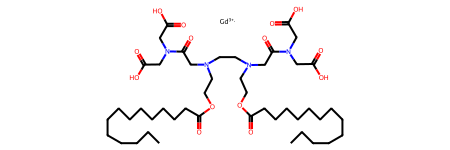

In [7]:
Chem.MolFromMolBlock(standard_parent)

## chembl_structure_pipeline で標準化前後の分子の構造を確認する
- [check_molblock](https://github.com/chembl/ChEMBL_Structure_Pipeline/blob/02fae41903d35e6bb853ee56cf6b799d774bfe92/chembl_structure_pipeline/checker.py#L487)にて処理できない分子を除外します。(以下のコード12行目)
- 次いでstandardize_molblockにて分子を標準化します。(以下のコード14行目)
- 最後にget_parent_molblockにて塩などを除去塩や化合物を取得します。
- 以下のコードでは分子の2つイメージとともに3つSMILESを出力します。
- SMILESは上から順に以下のものになります。
    1. 何も処理していない分子のSMILES 
    1. standardize_molblock実施後の分子のSMILES
    1. get_parent_molblock実施後(ここで同位体情報は削除されます)の分子のSMILES
- 出力しているイメージは以下のものになります。
    1. standardize_molblock実施後の分子
    1. get_parent_molblock実施後の分子
- なお最初のチェックで通らなかったもの、excludeに該当する分子についてはその後の処理をしていません。

In [8]:
from ipywidgets import interact,fixed
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')
@interact(idx=range(0,len(records)),records=fixed(records))
def show_standardized_mol(idx,records):
    record = records[idx]
    checks = chembl_structure_pipeline.check_molblock(record)
    if checks and checks[0][0]>6:
        print(f"Failed validation: {checks}")
        return None

    standard_record = chembl_structure_pipeline.standardize_molblock(record)
    standard_parent,exclude = chembl_structure_pipeline.get_parent_molblock(standard_record)
    m1 = Chem.MolFromMolBlock(record,sanitize=False)
    m1.UpdatePropertyCache(strict=False)
    Chem.GetSymmSSSR(m1)
    if exclude:
        print(f'Excluded: {Chem.MolToSmiles(m1)}')
        return m1
    m2 = Chem.MolFromMolBlock(standard_record,sanitize=False)
    m2.UpdatePropertyCache(strict=False)
    Chem.GetSymmSSSR(m2)
    m3 = Chem.MolFromMolBlock(standard_parent,sanitize=False)
    m3.UpdatePropertyCache(strict=False)
    Chem.GetSymmSSSR(m3)
    print(Chem.MolToSmiles(m1))
    print(Chem.MolToSmiles(m2))
    print(Chem.MolToSmiles(m3))
    d2d = rdMolDraw2D.MolDraw2DSVG(700,300,350,300)
    #d2d.drawOptions().prepareMolsBeforeDrawing=False
    d2d.DrawMolecules((m2,m3))
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

- 塩を含む分子はStandardize_molblockでは脱塩されません。以下の例のようにget_parent_molblockなどを利用し、parentmolを取得する必要があります

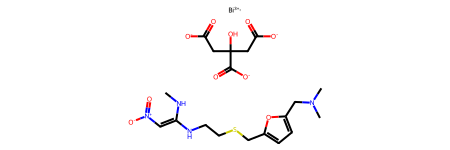

In [9]:
#CHEMBL2111286
from rdkit.Chem.Draw import IPythonConsole
# ineractiveRendererを利用すると分子の情報をコピーできたり再描画できたりします。通常の描画より動作が重くなります。
from rdkit.Chem.Draw import InteractiveRenderer
InteractiveRenderer.setEnabled(True)
mol = Chem.MolFromSmiles('CNC(=C[N+](=O)[O-])NCCSCC1=CC=C(O1)CN(C)C.C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O.[Bi+3]')
mol

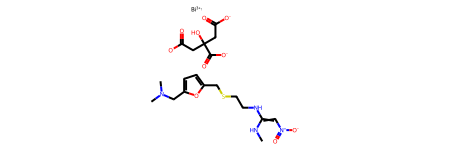

In [10]:
mb = Chem.MolToMolBlock(mol)
# standardizeでは脱塩はされません
sb = chembl_structure_pipeline.standardize_molblock(mb)
parentmb, exclude = chembl_structure_pipeline.get_parent_molblock(sb)
Chem.MolFromMolBlock(sb)

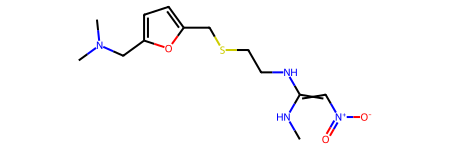

In [11]:
mb = Chem.MolToMolBlock(mol)
# standardizeでは脱塩はされません
sb = chembl_structure_pipeline.standardize_molblock(mb)
parentmb, exclude = chembl_structure_pipeline.get_parent_molblock(sb)
Chem.MolFromMolBlock(parentmb)

## 互変異性体の取り扱い
- structurepipelineは互変異性の取り扱いに対応していないので、RDKitのrdMolStandardizeモジュールを利用します。standardize_molでは互変異性体は正規化しないので、CanonicalTautomerで互変異性体で正規化します
- 正規化した分子はもとの分子のプロパティを保持します。

In [12]:
from rdkit.Chem.MolStandardize import rdMolStandardize
#from rdkit.Chem import rdMolHash
taut1 = Chem.MolFromSmiles('O=C1NC=CC=C1')
taut1.SetProp("molname","pyridone")
taut2 = Chem.MolFromSmiles('OC1=NC=CC=C1')
ctaut1 = rdMolStandardize.CanonicalTautomer(taut1)
print(ctaut1.GetPropsAsDict())
ctaut2 = rdMolStandardize.CanonicalTautomer(taut2)
Draw.MolsToGridImage([taut1, taut2, ctaut1, ctaut2], legends=['taut1', 'taut2', 'ctaut1', 'ctaut1'], molsPerRow=4)

{'molname': 'pyridone'}


"<div style=""width: 200px; height: 200px; margin: auto;"" class=""rdk-str-rnr-mol-container"" id=""rdk-str-rnr-mol-7d315394-62b7-11ee-bcd6-d0abd515655d"" data-mol=""pkl_776t3gAAAAANAAAAAAAAAAIAAAAHAAAABwAAAIABCAAoAAAAAwIGQCgAAAADBAdAOAAAAAMBAwZAaAAAAAMDAQZAaAAAAAMDAQZAaAAAAAMDAQZAaAAAAAMDAQsAASgCAQJoDAIDaAwDBGgMBAVoDAUGaAwGAWgMFAEAAAAGAQYFBAMCFwkAAAAAAAAAPwAAAAASHAAAAAEAAAAHAAAAbW9sbmFtZQAIAAAAcHlyaWRvbmUTOhwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEzscAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMW"" data-content=""rdkit/molecule"" data-parent-node=""div[class*=jp-NotebookPanel-notebook]""/>"
taut1
"<div style=""width: 200px; height: 200px; margin: auto;"" class=""rdk-str-rnr-mol-container"" id=""rdk-str-rnr-mol-7d3173d8-62b7-11ee-bcd6-d0abd515655d"" data-mol=""pkl_776t3gAAAAANAAAAAAAAAAIAAAAHAAAABwAAAIABCABoAAAAAwEBBkAoAAAAAwQHQCgAAAADAwZAaAAAAAMDAQZAaAAAAAMDAQZAaAAAAAMDAQZAaAAAAAMDAQsAASABAmgMAgNoDAMEaAwEBWgMBQZoDAYBaAwUAQAAAAYBBgUEAwIXCQAAAAAAAAA/AAAAABIEAAAAAAAAABM6HAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATOxwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAExY="" data-content=""rdkit/molecule"" data-parent-node=""div[class*=jp-NotebookPanel-notebook]""/>"
taut2
"<div style=""width: 200px; height: 200px; margin: auto;"" class=""rdk-str-rnr-mol-container"" id=""rdk-str-rnr-mol-7d31911a-62b7-11ee-bcd6-d0abd515655d"" data-mol=""pkl_776t3gAAAAANAAAAAAAAAAIAAAAHAAAABwAAAIABCAAoAAAAAwIGQCgAAAADBAdAOAAAAAMBAwZAaAAAAAMDAQZAaAAAAAMDAQZAaAAAAAMDAQZAaAAAAAMDAQsAASgCAQJoDAIDaAwDBGgMBAVoDAUGaAwGAWgMFAEAAAAGAQYFBAMCFwkAAAAAAAAAPwAAAAASHAAAAAEAAAAHAAAAbW9sbmFtZQAIAAAAcHlyaWRvbmUTOhwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEzscAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMW"" data-content=""rdkit/molecule"" data-parent-node=""div[class*=jp-NotebookPanel-notebook]""/>"
ctaut1
"<div style=""width: 200px; height: 200px; margin: auto;"" class=""rdk-str-rnr-mol-container"" id=""rdk-str-rnr-mol-7d31abbe-62b7-11ee-bcd6-d0abd515655d"" data-mol=""pkl_776t3gAAAAANAAAAAAAAAAIAAAAHAAAABwAAAIABCCBoAAAAAwIBBkAoAAAAAwQHQDgAAAADAQMGQGgAAAADAwEGQGgAAAADAwEGQGgAAAADAwEGQGgAAAADAwELAAEoAgECaAwCA2gMAwRoDAQFaAwFBmgMBgFoDBQBAAAABgEGBQQDAhcJAAAAAAAAAD8AAAAAEgQAAAAAAAAAEzocAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABM7HAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATFg=="" data-content=""rdkit/molecule"" data-parent-node=""div[class*=jp-NotebookPanel-notebook]""/>"
ctaut1


- 互変異性体が正規化されました。次は、最初の互変異性体からenumerateします。
- enumerateされた分子ももとのプロパティを保持しています。

In [13]:
enum = rdMolStandardize.TautomerEnumerator()
taus = [m for m in enum.Enumerate(taut1)]
print(taus[0].GetPropsAsDict())
Draw.MolsToGridImage(taus)

{'molname': 'pyridone'}


"<div style=""width: 200px; height: 200px; margin: auto;"" class=""rdk-str-rnr-mol-container"" id=""rdk-str-rnr-mol-7d3307f2-62b7-11ee-bcd6-d0abd515655d"" data-mol=""pkl_776t3gAAAAANAAAAAAAAAAIAAAAHAAAABwAAAIABCAAoAAAAAwIGQCgAAAADBAdAOAAAAAMBAwZAaAAAAAMDAQZAaAAAAAMDAQZAaAAAAAMDAQZAaAAAAAMDAQsAASgCAQJoDAIDaAwDBGgMBAVoDAUGaAwGAWgMFAEAAAAGAQYFBAMCFwkAAAAAAAAAPwAAAAASHAAAAAEAAAAHAAAAbW9sbmFtZQAIAAAAcHlyaWRvbmUTOhwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEzscAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMW"" data-content=""rdkit/molecule"" data-parent-node=""div[class*=jp-NotebookPanel-notebook]""/>","<div style=""width: 200px; height: 200px; margin: auto;"" class=""rdk-str-rnr-mol-container"" id=""rdk-str-rnr-mol-7d333768-62b7-11ee-bcd6-d0abd515655d"" data-mol=""pkl_776t3gAAAAANAAAAAAAAAAIAAAAHAAAABwAAAIABCCA4AAAAAwECBkAoAAAAAwQHYCgAAAADAwZAaAAAAAMDAQZAaAAAAAMDAQZAaAAAAAMDAQZAaAAAAAMDAQsAASABAmgMAgNoDAMEaAwEBWgMBQZoDAYBaAwUAQAAAAYBBgUEAwIXCQAAAAAAAAA/AAAAABIcAAAAAQAAAAcAAABtb2xuYW1lAAgAAABweXJpZG9uZRM6HAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATOxwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAExY="" data-content=""rdkit/molecule"" data-parent-node=""div[class*=jp-NotebookPanel-notebook]""/>"


## TIPs
- RDKit UGM2023でも1hrほど議論がありましたが、RDKitに実装されている互変異整体の正規化は、あくまである一定のルールに従って分子を正規化するという目的のために使うべきです。化学的に正しい互変異整体を出力するかという問いかけに対する回答とは別に考えるべきです。
- 正確な互変異整体の存在比率などを検証したい場合は実験的なアプローチや別の計算的なアプローチを検討されることをおすすめいたします。

## カルボン酸塩の取り扱い

カルボン酸のNa塩などはよく出てくる構造です。これらの構造はchembl_structure_pipelineではカルボン酸塩のまま処理されるため、脱塩したい場合は以下のような手順を踏む必要があります。アミンの塩場合と合わせて確認してみましょう。

rdMolStandardizeを利用して処理します。

#### rdMolStandardize.Reionizer and rdMolStandardizer.Uncharger
- rdMolStandardize.Reionizer ensure the strongest acid groups ionize first in partially ionized molecules.
- rdMolStandardize.Uncharger attempts to neutralize charges by adding and/or removing hydrogens where possible.
-  rdMolStandardize.ChargeParent() method is the uncharged version of the fragment parent. It involves taking the fragment parent then applying Neutralize and Reionize.

In [14]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

In [15]:
uc = rdMolStandardize.Uncharger()

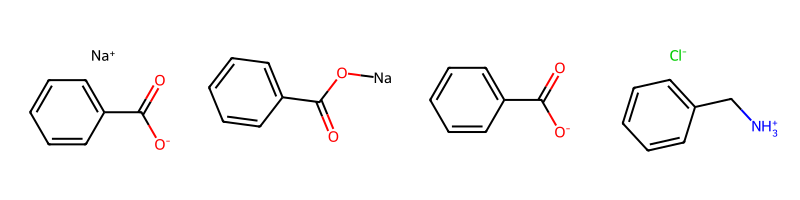

In [16]:
InteractiveRenderer.setEnabled(False)
mol1 = Chem.MolFromSmiles('c1ccccc1C(=O)[O-].[Na+]')
mol2 = Chem.MolFromSmiles('c1ccccc1C(=O)O[Na]')
mol3 = Chem.MolFromSmiles('c1ccccc1C(=O)[O-]')
mol4 = Chem.MolFromSmiles('c1ccccc1C[N+]([H])([H])[H].[Cl-]')

Draw.MolsToGridImage([mol1, mol2, mol3, mol4], molsPerRow=4)

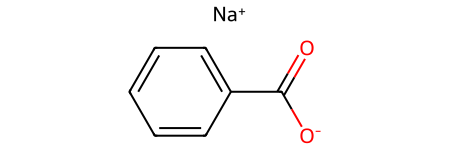

In [17]:
#Unchargerをつかってもカルボン酸の塩はそのままで脱塩はされません。
uc.uncharge(mol1)

# LargestFragmentChooserを利用し、大きなカルボン酸を取得し、中性化することで中性のカルボン酸を得ることができます。

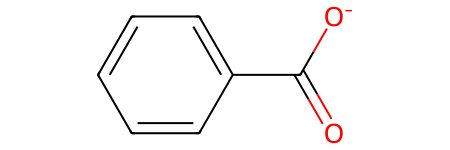

In [18]:
lfc = rdMolStandardize.LargestFragmentChooser()
mol = lfc.choose(mol1)
mol

## 演習

ここまでのフローをベースに分子の正規化を行う関数を作成してください。


In [19]:
# Taka's example　（当日は空白）
def standardizemol(mol):
    stdmol = chembl_structure_pipeline.standardize_mol(mol)
    chooser = rdMolStandardize.LargestFragmentChooser()
    lmol = chooser.choose(stdmol)
    pmol, _ = get_parent_mol(lmol)
    pmol = rdMolStandardize.CanonicalTautomer(pmol)
    return pmol

# 補足

## chembl_structure_pipelineの主要な関数
### standardize_molblock()
- Exclude flagに含まれる金属を含む場合は何もしません。
- それ以外の場合に以下の処理を行います。
 1. 立体情報をを持たないSP3炭素にunknown stereoからno stereoのフラグ付与
 1. 立体情報が不明な二重結合をcrossed bondと指定
 1. S Groupの情報を削除
 1. 構造のケクレ化
 1. 水素の除去
 1. 標準化
    1. ニトロ基標準化
    1. KO, NaOなどをK+O- Na+O-などとする。
    1. N=COHという表記のアミド部分の修正
    1. スルホキシドを電化が分離した状態表現に変更
    1. ジアゾニウム部分の標準化
    1. 4級窒素原子が適切なチャージを持ているかチェック
    1. 3価のO（[*:1]=[O;X2;v3;+0:2]-[#6:3]）がチャージされていることを確認する。
    1. 3価のS（[O:1]=[S;D2;+0:2]-[#6:3]）が帯電していることを確認する。
    1. 隣接原子を持たないハロゲン（[F,Cl,Br,I;X0;+0:1]）が帯電していることを確認する。
  1. 可能であれば分子を中性化
  1. 塩のマッチングを用意にするため酒石酸の立体情報を削除
  1. 3重結合とアレン結合を直線状に修正する。

### get_parent_molblock()
1. すべての同位体を0に設定し、Hsを除去する。以前のH除去ではD原子やT原子をスキップしていたため、この余分なH除去ステップが必要である（詳細は明示的Hsのページを参照）。
1. 溶媒(リストで定義)は、このステップですべてのフラグメントが除去されない限り除去される。
1. 塩（リストで定義）は、このステップですべてのフラグメントが削除されない限り削除される。
1. 重複フラグメント（中和してフラグメントからHsを除去した後に検出された重複）は除去される。重複はcanonical SMILESを使用して検出されるため、互変異性であるフラグメントはこのステップでは削除されない。
1. 可能であれば、残った分子を中和する。詳細は中和ルールのページを参照。
1. 除外フラグがチェックされる（詳細は除外フラグのページを参照）。フラグがセットされていれば、溶媒ストリッピング後に残った分子を返す。これがどのような違いを生むかを示す2つの具体例として、クエン酸ラニチジンビスマス(CHEMBL2111286) - Biイオンが塩として取り除かれ、ラニチジンが親 - とCuCl2.2H2O - 水(溶媒)と塩化物イオン(塩)が取り除かれるが、除外フラグがCu+2によって設定されるため、親はCuCl2となる。

## chembl_structure_pipeline.standardize_molの挙動
- 互変異性体の正規化には対応していないことがわかります。

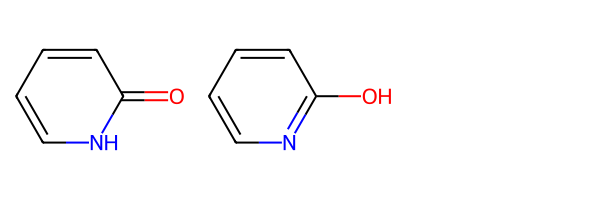

In [20]:
## example
taut1 = Chem.MolFromSmiles('O=C1NC=CC=C1')
taut2 = Chem.MolFromSmiles('OC1=NC=CC=C1')
Draw.MolsToGridImage([taut1, taut2])

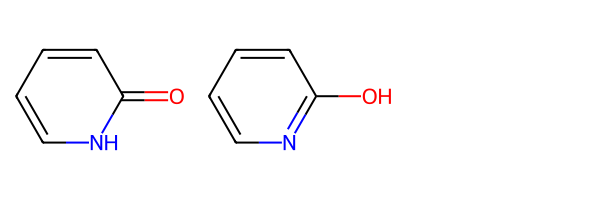

In [21]:
st_taut1 = chembl_structure_pipeline.standardize_mol(taut1)
st_taut2 = chembl_structure_pipeline.standardize_mol(taut2)
Draw.MolsToGridImage([st_taut1, st_taut2])

## chembl_structure_pipelineでのカルボン酸塩の取り扱い
- CanonicalTautomerで互変異性体で正規化
- TautomerEnumeratorを利用することで互変異性体をEnumerateします

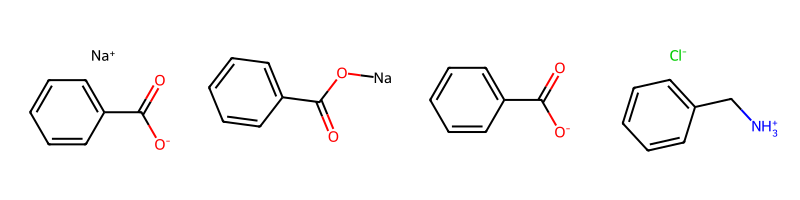

In [22]:
InteractiveRenderer.setEnabled(False)
mol1 = Chem.MolFromSmiles('c1ccccc1C(=O)[O-].[Na+]')
mol2 = Chem.MolFromSmiles('c1ccccc1C(=O)O[Na]')
mol3 = Chem.MolFromSmiles('c1ccccc1C(=O)[O-]')
mol4 = Chem.MolFromSmiles('c1ccccc1C[N+]([H])([H])[H].[Cl-]')
for i, m in enumerate([mol1, mol2, mol3, mol4]):
    m.SetProp('molid', f'mol_{i}')
Draw.MolsToGridImage([mol1, mol2, mol3, mol4], molsPerRow=4)

{}


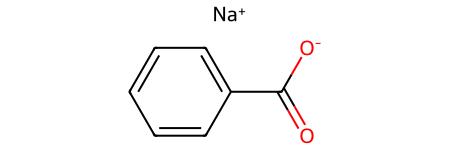

In [23]:
# もとの分子のプロパティは保持しません！！
std_mol1 = chembl_structure_pipeline.standardize_mol(mol1)
print(std_mol1.GetPropsAsDict())
std_mol1

{}


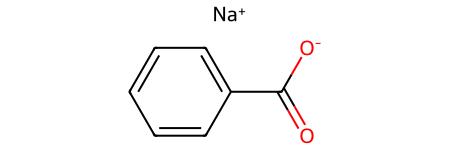

In [24]:
# O[Na]が分離されました
# もとの分子のプロパティは保持しません！！
std_mol2 = chembl_structure_pipeline.standardize_mol(mol2)
print(std_mol2.GetPropsAsDict())
std_mol2

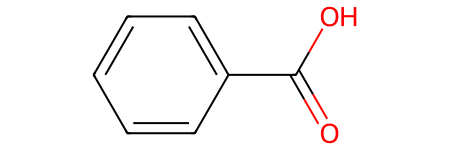

In [25]:
# カルボキシルアニオンが中性になりました
chembl_structure_pipeline.standardize_mol(mol3)

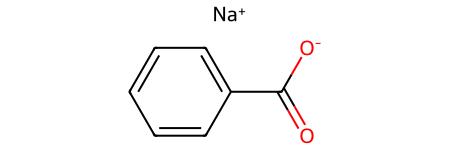

In [26]:
pmol, s = chembl_structure_pipeline.get_parent_mol(mol1)
pmol

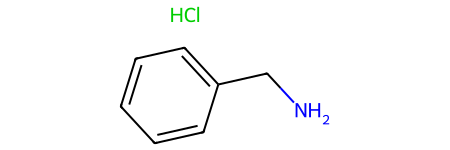

In [27]:
# アミンは中性化されます。
chembl_structure_pipeline.standardize_mol(mol4)

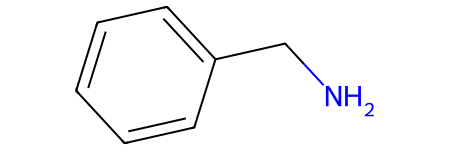

In [28]:
pmol, _ = get_parent_mol(mol4)
pmol

### Acknowledgements
- The most of code came from Greg's great tutorial.
- Thank Greg for acceppting share his great work!
- https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/Standardization%20and%20Validation%20with%20the%20RDKit.ipynb

## ToDo
- リポジトリの最上階層にあるcheminfo_util.pyのprep_moleclueを完成させて下さい。
- 要件
    1. 互変異性体を正規化する。
    2. 分子を標準化する。
    3. 塩や後の処理に開く盈虚を与えそうな金属などを除去する。（*Excludeに該当する金属を含む場合Omittするか、金属を除去するかは任意です。）
    4. 処理後の分子はプロパティがなくなるので、もとの分子から情報を取得し処理後に付与して下さい。GetPropsAsDictを利用し全ての情報(_Nameを除く)を取得できます。